In [39]:
#preprocessing
import numpy as np
import random

#plotting
import matplotlib.pyplot as plt

#connectivity measures
import nilearn.connectome as nic

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, SVR
from imblearn.over_sampling import RandomOverSampler

In [43]:
def analysis(y_test, y_pred, threshold=None):
    if threshold is not None:
        y_test = (y_test < -threshold).astype(int)
        y_pred = (y_pred < -threshold).astype(int)
    
    # Create the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print("Confusion Matrix:")
    print(conf_matrix)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = ( tp + tn ) / (tp+tn+fp+fn)
    print('Precision', precision)
    print('Recall', recall)
    return accuracy, recall, precision
    

In [3]:
%run loading_data.ipynb

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



In [4]:
sub_data, sub_ids = load_txt()

Subject Data Loaded


In [5]:
unrestricted = load_unrestricted()

unrestricted_data loaded


In [44]:
handedness = get_handedness(sub_ids)

restricted_data loaded


In [7]:
atlas = load_atlas()
atlas_coords = get_atlas_coords(atlas)

/tmp/ipykernel_353/1030149754.py:16: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  atlas = image.threshold_img(atlas, "99.5%")


atlas has shape ['x', 'y', 'z', 'region'] = (91, 109, 91, 100)


In [14]:
correlation_measure = nic.ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform(sub_data)

In [16]:
rois = [37, 40, 42]

In [17]:
dataX = correlation_matrix[:, :, rois]

In [45]:
X = []
gender = handedness.reset_index().merge(unrestricted[['Subject','Gender']], on='Subject')
for i in range(len(dataX)):
    data = dataX[i]
    gdr = 1 if gender['Gender'].iloc[i] == 'M' else 0
    
    inner = []
    for i in range(3):
        row = data[:, 1]
        row = np.array(list(filter(lambda x: x != 1.000, row)))
        inner.extend(np.arctanh(row))
    inner += [gdr]
    X.append(inner)

In [46]:
X = np.array(X)

In [47]:
X

array([[-0.2818701 , -0.13788241,  0.04965595, ..., -0.07529602,
        -0.2551537 ,  0.        ],
       [-0.09541342, -0.29191671,  0.0680977 , ..., -0.19320254,
        -0.22009913,  1.        ],
       [-0.35412518, -0.07263859, -0.05284884, ..., -0.10978117,
        -0.06765132,  1.        ],
       ...,
       [-0.23406598, -0.13724782,  0.1789111 , ..., -0.13942194,
        -0.12974863,  0.        ],
       [ 0.06281866,  0.04862226,  0.20709745, ..., -0.19691202,
        -0.11050726,  1.        ],
       [-0.36803797, -0.26243221,  0.29946735, ..., -0.2107835 ,
        -0.15535327,  1.        ]], shape=(1003, 298))

In [56]:
threshold = 25
handedness = handedness.reset_index()
handedness['Class'] = handedness['Handedness']
handedness = handedness[(handedness['Handedness'] > threshold) | (handedness['Handedness'] < -threshold)]
handedness.loc[handedness['Class'] > threshold, 'Class'] = 0
handedness.loc[handedness['Class'] < -threshold, 'Class'] = 1

In [57]:
X = X[handedness.index]

In [58]:
distribution = {'accuracy': [], 'recall': [], 'precision': []}
for i in range(100):
    #train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, handedness['Class'], test_size=0.1)

    #oversampling X_train
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    from collections import Counter
    print(sorted(Counter(y_resampled).items()))

    model = SVC(gamma='auto')
    model.fit(X_resampled, y_resampled)

    y_pred = model.predict(X_test)

    accuracy, recall, precision = analysis(y_test, y_pred)
    distribution['accuracy'].append(accuracy)
    distribution['recall'].append(recall)
    distribution['precision'].append(precision)

[(0, 805), (1, 805)]
Confusion Matrix:
[[50 36]
 [ 8  3]]
Precision 0.07692307692307693
Recall 0.2727272727272727
[(0, 800), (1, 800)]
Confusion Matrix:
[[61 30]
 [ 4  2]]
Precision 0.0625
Recall 0.3333333333333333
[(0, 799), (1, 799)]
Confusion Matrix:
[[59 33]
 [ 4  1]]
Precision 0.029411764705882353
Recall 0.2
[(0, 805), (1, 805)]
Confusion Matrix:
[[70 16]
 [ 6  5]]
Precision 0.23809523809523808
Recall 0.45454545454545453
[(0, 799), (1, 799)]
Confusion Matrix:
[[71 21]
 [ 2  3]]
Precision 0.125
Recall 0.6
[(0, 799), (1, 799)]
Confusion Matrix:
[[57 35]
 [ 1  4]]
Precision 0.10256410256410256
Recall 0.8
[(0, 800), (1, 800)]
Confusion Matrix:
[[67 24]
 [ 4  2]]
Precision 0.07692307692307693
Recall 0.3333333333333333
[(0, 803), (1, 803)]
Confusion Matrix:
[[64 24]
 [ 6  3]]
Precision 0.1111111111111111
Recall 0.3333333333333333
[(0, 800), (1, 800)]
Confusion Matrix:
[[62 29]
 [ 5  1]]
Precision 0.03333333333333333
Recall 0.16666666666666666
[(0, 798), (1, 798)]
Confusion Matrix:
[[65 

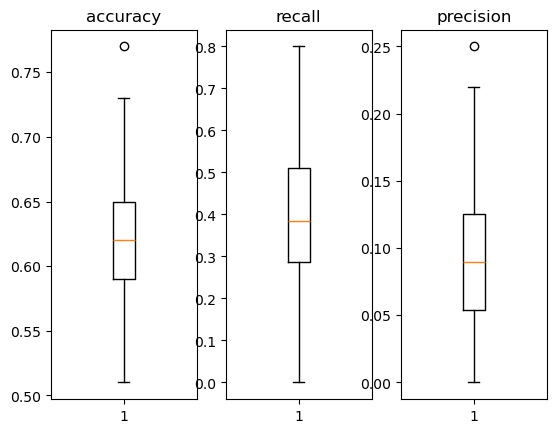

In [55]:
fig, axes = plt.subplots(1, 3)

for i in range(len(distribution)):
    key = list(distribution.keys())[i]
    axes[i].boxplot(distribution[key])
    axes[i].set_title(f'{key}')

In [91]:
#oversampling X_train
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 684), (1, 684)]


In [92]:
model = SVC(gamma='auto')
model.fit(X_resampled, y_resampled)

SVC(gamma='auto')

In [93]:
y_pred = model.predict(X_test)

In [94]:
analysis(y_test, y_pred)

Confusion Matrix:
[[  9  14]
 [ 88 140]]
Precision 0.9090909090909091
Recall 0.6140350877192983


In [36]:
distribution = {'accuracy': [], 'recall': [], 'precision': []}
for i in range(100):
    #train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, handedness['Handedness'], test_size=0.1)

    #oversampling X_train
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    from collections import Counter
    print(sorted(Counter(y_resampled).items()))

    model = SVR()
    model.fit(X_resampled, y_resampled)

    y_pred = model.predict(X_test)

    accuracy, recall, precision = analysis(y_test, y_pred, threshold=0)
    distribution['accuracy'].append(accuracy)
    distribution['recall'].append(recall)
    distribution['precision'].append(precision)

[(-100, 170), (-95, 170), (-90, 170), (-85, 170), (-80, 170), (-75, 170), (-70, 170), (-65, 170), (-60, 170), (-55, 170), (-50, 170), (-45, 170), (-40, 170), (-35, 170), (-30, 170), (-25, 170), (-20, 170), (-15, 170), (-10, 170), (-5, 170), (5, 170), (10, 170), (15, 170), (20, 170), (25, 170), (30, 170), (35, 170), (40, 170), (45, 170), (50, 170), (55, 170), (60, 170), (65, 170), (70, 170), (75, 170), (80, 170), (85, 170), (90, 170), (95, 170), (100, 170)]
Confusion Matrix:
[[ 4  3]
 [29 64]]
Precision 0.9552238805970149
Recall 0.6881720430107527
[(-100, 171), (-95, 171), (-90, 171), (-85, 171), (-80, 171), (-75, 171), (-70, 171), (-65, 171), (-60, 171), (-55, 171), (-50, 171), (-45, 171), (-40, 171), (-35, 171), (-30, 171), (-25, 171), (-20, 171), (-15, 171), (-10, 171), (-5, 171), (5, 171), (10, 171), (15, 171), (20, 171), (25, 171), (30, 171), (35, 171), (40, 171), (45, 171), (50, 171), (55, 171), (60, 171), (65, 171), (70, 171), (75, 171), (80, 171), (85, 171), (90, 171), (95, 171)

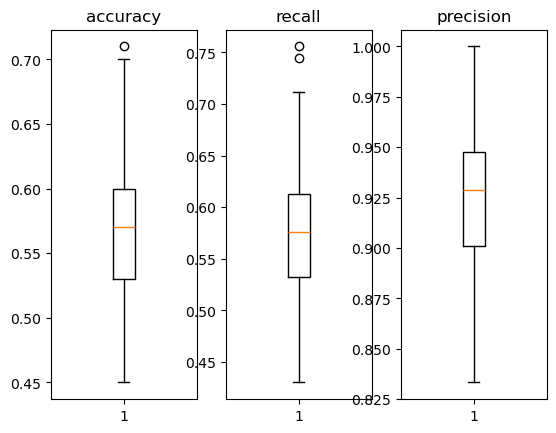

In [37]:
fig, axes = plt.subplots(1, 3)

for i in range(len(distribution)):
    key = list(distribution.keys())[i]
    axes[i].boxplot(distribution[key])
    axes[i].set_title(f'{key}')

In [40]:
distribution = {'accuracy': [], 'recall': [], 'precision': []}
for i in range(100):
    #train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, handedness['Handedness'], test_size=0.1)

    #oversampling X_train
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    from collections import Counter
    print(sorted(Counter(y_resampled).items()))

    model = SGDRegressor(alpha=0.1, warm_start=True)
    model.fit(X_resampled, y_resampled)

    y_pred = model.predict(X_test)

    accuracy, recall, precision = analysis(y_test, y_pred, threshold=0)
    distribution['accuracy'].append(accuracy)
    distribution['recall'].append(recall)
    distribution['precision'].append(precision)

[(-100, 175), (-95, 175), (-90, 175), (-85, 175), (-80, 175), (-75, 175), (-70, 175), (-65, 175), (-60, 175), (-55, 175), (-50, 175), (-45, 175), (-40, 175), (-35, 175), (-30, 175), (-25, 175), (-20, 175), (-15, 175), (-10, 175), (-5, 175), (5, 175), (10, 175), (15, 175), (20, 175), (25, 175), (30, 175), (35, 175), (40, 175), (45, 175), (50, 175), (55, 175), (60, 175), (65, 175), (70, 175), (75, 175), (80, 175), (85, 175), (90, 175), (95, 175), (100, 175)]
Confusion Matrix:
[[ 5  1]
 [42 52]]
Precision 0.9811320754716981
Recall 0.5531914893617021
[(-100, 169), (-95, 169), (-90, 169), (-85, 169), (-80, 169), (-75, 169), (-70, 169), (-65, 169), (-60, 169), (-55, 169), (-50, 169), (-45, 169), (-40, 169), (-35, 169), (-30, 169), (-25, 169), (-20, 169), (-15, 169), (-10, 169), (-5, 169), (5, 169), (10, 169), (15, 169), (20, 169), (25, 169), (30, 169), (35, 169), (40, 169), (45, 169), (50, 169), (55, 169), (60, 169), (65, 169), (70, 169), (75, 169), (80, 169), (85, 169), (90, 169), (95, 169)

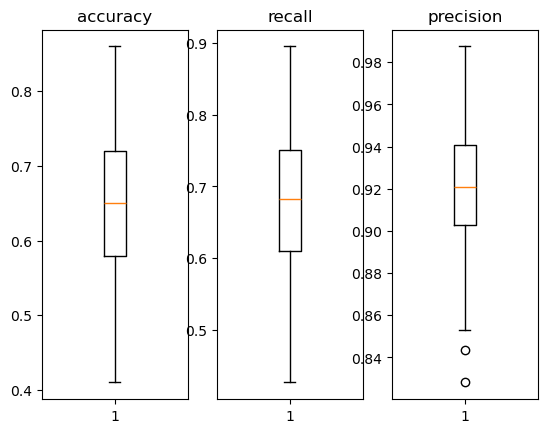

In [41]:
fig, axes = plt.subplots(1, 3)

for i in range(len(distribution)):
    key = list(distribution.keys())[i]
    axes[i].boxplot(distribution[key])
    axes[i].set_title(f'{key}')